In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import fanc
import fanc.plotting
from scipy import ndimage as ndi
import matplotlib.patches as patches
from scipy.ndimage import zoom
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os
import seaborn as sns
from sklearn.decomposition import PCA
import math
from skimage.metrics import structural_similarity as ssim
import cv2

In [2]:
def clipped_zoom(img, zoom_factor, **kwargs):
    h, w = img.shape[:2]
    zoom_tuple = (zoom_factor,) * 2 + (1,) * (img.ndim - 2)
    if zoom_factor < 1:
        zh = int(np.round(h * zoom_factor))
        zw = int(np.round(w * zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2
        out = np.zeros_like(img)
        out[top:top+zh, left:left+zw] = zoom(img, zoom_tuple, **kwargs)
    elif zoom_factor > 1:
        zh = int(np.round(h / zoom_factor))
        zw = int(np.round(w / zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2
        out = zoom(img[top:top+zh, left:left+zw], zoom_tuple, **kwargs)
        trim_top = ((out.shape[0] - h) // 2)
        trim_left = ((out.shape[1] - w) // 2)
        out = out[trim_top:trim_top+h, trim_left:trim_left+w]
    else:
        out = img
    return out

def add_noise_and_blur(matrix: np.array, noise_level: float, blur_strength: int) -> np.array:
    """
    Add noise and apply blur to a Hi-C matrix.

    Parameters:
        matrix (np.array): Input Hi-C matrix with values between 0 and 0.03.
        noise_level (float): The standard deviation of Gaussian noise.
        blur_strength (int): Kernel size for the blur effect (should be an odd number).

    Returns:
        np.array: The modified matrix with noise and blur.
    """
    # Add Gaussian noise
    noise = np.random.normal(0, noise_level, matrix.shape)
    noisy_matrix = matrix + noise

    # Clip values to keep them within the original range
    # noisy_matrix = np.clip(noisy_matrix, 0, 0.03)

    # Apply Gaussian blur (blur_strength should be odd)
    if blur_strength % 2 == 0:
        blur_strength += 1  # Ensure it's odd
    
    blurred_matrix = cv2.GaussianBlur(noisy_matrix, (blur_strength, blur_strength), 0)

    return blurred_matrix


def clip_rotate(matrix):
    zm = clipped_zoom(matrix, 0.7)
    rot_clipped = ndi.rotate(zm, 45, reshape=False)
    return rot_clipped

In [3]:
winsize = "3mb"
wdir = "../data/dlbcl/"
region_pairs = "hg38_chr2_{}_win_100kb_step.bed".format(winsize)

gained = pd.read_csv(wdir + 'gained_features.tsv', delimiter=',', usecols=[0, 1, 2, 3, 4, 5], header=None, index_col=[0])
lost = pd.read_csv(wdir + 'lost_features.tsv', delimiter=',', usecols=[0, 1, 2, 3, 4, 5], header=None, index_col=[0])

regions = pd.read_csv(wdir + region_pairs, sep='\t', header=None)

patient_hic = fanc.load(wdir + "ukm_patient_fixed_le_25kb_chr2.hic")
control_hic = fanc.load(wdir + "ukm_control_fixed_le_25kb_chr2.hic")

reg = 1448

window_start, window_end = regions.loc[reg][1:3]

region_string = "chr2:{}-{}".format(window_start, window_end)

patient_region_sub = patient_hic[region_string, region_string].data
control_region_sub = control_hic[region_string, region_string].data

min_v = min(
    [
        np.min(np.extract(patient_region_sub>0 , patient_region_sub)),
        np.min(np.extract(control_region_sub>0 , control_region_sub))
    ]
)

patient_region_sub += min_v
control_region_sub += min_v
print("loaded hic")

loaded hic


In [4]:
# Set var size
noise_level = 0.005
blur_strength = 2

# raw matrices
rot_patient = clip_rotate(patient_region_sub)

rot_control = clip_rotate(control_region_sub)

# Apply PCA
pca_matrix1 = add_noise_and_blur(patient_region_sub, noise_level, blur_strength)
rot_pca1 = clip_rotate(pca_matrix1) 

pca_matrix2 = add_noise_and_blur(control_region_sub, noise_level, blur_strength)
rot_pca2 = clip_rotate(pca_matrix2)

# Compute PCA difference matrix (patient - control)
diff_pca1 = pca_matrix1 - pca_matrix2 # pca_matrix1 - pca_matrix2
rot_diff_pca1 = clip_rotate(diff_pca1)

# subtract inverse (control - patient)
diff_pca2 = pca_matrix2 - pca_matrix1
rot_diff_pca2 = clip_rotate(diff_pca2)

# log2(obs/exp) calc
safe_div = pca_matrix1 / pca_matrix2
safe_div[safe_div == 0] = np.nan
safe_div = abs(safe_div)
log_pca1 =  np.log2(safe_div) # pca_matrix1 / pca_matrix2 of pca applied
rot_log_pca1 = clip_rotate(log_pca1)

log_pca2 =  np.log2(patient_region_sub / control_region_sub) # pca_matrix1 / pca_matrix2 of normal matrices
rot_log_pca2 = clip_rotate(log_pca2)

Plot saved to out/mf_hic.png


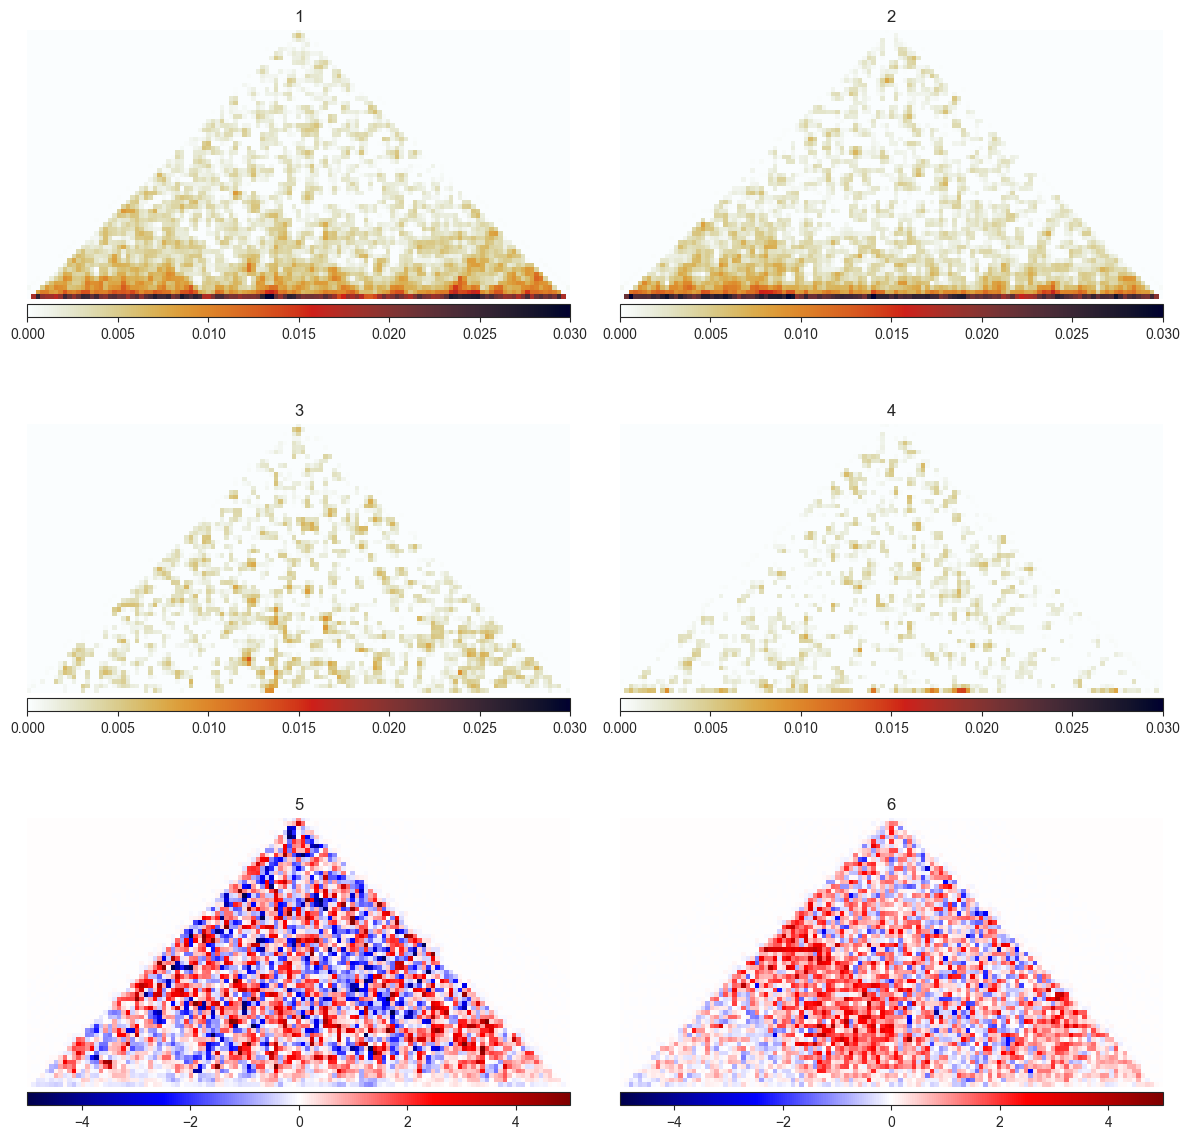

In [5]:
# Plot heatmaps in a grid layout
fig, axes = plt.subplots(3, 2, figsize=(12, 12))

middle = int(np.shape(rot_control)[1]/ 2.)

# Second row: PCA transformed matrices
m1 = axes[0][0].imshow(rot_pca1[:middle, :], vmin=0, vmax=0.03, cmap='germany')
axes[0, 0].set_title("1")

m2 = axes[0][1].imshow(rot_pca2[:middle, :], vmin=0, vmax=0.03, cmap='germany')
axes[0, 1].set_title("2")

# Third row: Difference matrix spanning two columns
m3 = axes[1][0].imshow(rot_diff_pca1[:middle, :], vmin=0, vmax=0.03, cmap='germany')
axes[1, 0].set_title("3")

m4 = axes[1][1].imshow(rot_diff_pca2[:middle, :], vmin=0, vmax=0.03, cmap='germany')
axes[1, 1].set_title("4")

# Fourth Row:
# apply log2(obs/exp) from pca modified matrices and raw matrices
m5 = axes[2][0].imshow(rot_log_pca1[:middle, :], vmin=-5, vmax=5, cmap='seismic')
axes[2, 0].set_title("5")

m6 = axes[2][1].imshow(rot_log_pca2[:middle, :], vmin=-5, vmax=5, cmap='seismic')
axes[2, 1].set_title("6")

color_bars = [m1, m2, m3, m4, m5, m6]

for i in range(0, len(axes)):
    for m, ax in zip([color_bars[i*2+1], color_bars[i*2+1]], axes[i]):
        ax.axis('off')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('bottom', size='5%', pad=0.05)
        fig.colorbar(m, cax=cax, orientation='horizontal') 

# Adjust layout
plt.tight_layout()

# save plot
save_path = os.path.join("out", "mf_hic.png")
plt.savefig(save_path, dpi=300, bbox_inches='tight')  # High resolution and tight layout

print(f"Plot saved to {save_path}")
# TODO mse value calc
# mse_value = mean_squared_error(pca_matrix1, patient_region_sub)
# print(f"mse value {mse_value}")

In [6]:
def collect_windows(matrix, window_size):
    """ Extracts all sliding windows from the matrix for PCA. """
    m, n = matrix.shape
    windows = []

    for i in range(0, m - window_size + 1):
        for j in range(0, n - window_size + 1):
            window = matrix[i:i+window_size, j:j+window_size].flatten()
            windows.append(window)  # Collect all windows

    return np.array(windows)

def reconstruct_from_windows(windows, original_shape, window_size):
    """
    Reassemble a matrix from overlapping windows.
    This averages overlapping regions to smooth out reconstructions.
    """
    reconstructed = np.zeros(original_shape)
    count = np.zeros(original_shape)

    idx = 0
    for i in range(original_shape[0] - window_size + 1):
        for j in range(original_shape[1] - window_size + 1):
            reconstructed[i:i+window_size, j:j+window_size] += windows[idx].reshape((window_size, window_size))
            count[i:i+window_size, j:j+window_size] += 1
            idx += 1

    return reconstructed / np.maximum(count, 1)  # Avoid division by zero

def apply_pca(matrix, window_size=3, n_components=0.95):
    """
    Apply PCA to sliding windows and reconstruct the matrix with the same shape.
    """
    windows = collect_windows(matrix, window_size)  # Get windows (flattened)
    
    pca = PCA(n_components=n_components)
    transformed_windows = pca.fit_transform(windows)  # Reduce dimensionality
    reconstructed_windows = pca.inverse_transform(transformed_windows)  # Reconstruct
    
    # Reshape reconstructed windows back to original form
    reconstructed_matrix = reconstruct_from_windows(reconstructed_windows, matrix.shape, window_size)

    return reconstructed_matrix

# Build Autoencoder
def build_autoencoder(input_dim, encoding_dim):
    model = Sequential()
    model.add(Dense(encoding_dim, input_dim=input_dim, activation='relu'))
    model.add(Dense(input_dim, activation='linear'))  # Linear output activation
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def apply_autoencoder(matrix, encode_dim=40):
    model = build_autoencoder(input_dim=len(matrix), encoding_dim=encode_dim)
    # Normalize the matrix
    scaler = MinMaxScaler()
    matrix_scaled = scaler.fit_transform(matrix)
    
    model.fit(matrix_scaled, matrix_scaled, epochs=50, batch_size=32)
    denoised_matrix_scaled = model.predict(matrix_scaled) # denoise
    
    denoised_matrix = scaler.inverse_transform(denoised_matrix_scaled) # rescale
    return denoised_matrix

def matrix_factorization(matrix, n_components=15):
    svd = TruncatedSVD(n_components=n_components)
    return svd.fit_transform(matrix).dot(svd.components_)

def svt(matrix, threshold=0.04):
    U, S, Vt = svd(matrix, full_matrices=False)
    S_thresholded = np.maximum(S - threshold, 0)  # Shrink singular values
    return np.dot(U, np.dot(np.diag(S_thresholded), Vt))

In [7]:
def mean_squared_error(matrix_1, matrix_2):
    return np.mean((matrix_1 - matrix_2) ** 2)

def root_mean_squared_error(matrix_1, matrix_2):
    return np.sqrt(mean_squared_error(matrix_1, matrix_2))

def structural_similarity(matrix_1, matrix_2):
    return ssim(matrix_1, matrix_2, data_range=matrix_1.max() - matrix_1.min())

def explained_variance_score(matrix_1, matrix_2):
    variance_original = np.var(matrix_1)
    variance_error = np.var(matrix_1 - matrix_2)
    return 1 - (variance_error / variance_original)

In [8]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
from skimage.metrics import structural_similarity as ssim

import seaborn as sns
from sklearn.decomposition import PCA
import math

from sklearn.decomposition import TruncatedSVD

from numpy.linalg import svd

# keep blur the same, increment noise_level for n different levels

# add them to patient region

noise_levels = [0, 0.005, 0.01, 0.015, 0.03, 0.035, 0.04, 0.05, 0.08, 0.09, 0.1] 

noisy_matrices = []

# add noise to matrices
i = 0
for n in noise_levels:
    noisy_matrices.append(add_noise_and_blur(patient_region_sub, n, blur_strength))
    i += 1
    
# compute denoise on each noisy matrix
pca_denoised = []

auto_denoised = []

mf_denoised = []

svt_denoised = []

for matrix in noisy_matrices:
    pca_denoised.append(apply_pca(matrix))
    auto_denoised.append(apply_autoencoder(matrix))
    mf_denoised.append(matrix_factorization(matrix))
    svt_denoised.append(svt(matrix))

for m in pca_denoised:
    print(m.shape)

original = patient_region_sub
pca_stat = []
auto_stat = []
mf_stat = []
svt_stat = []

for k in range(0, len(noise_levels)):
    pca_stat.append(structural_similarity(noisy_matrices[k], pca_denoised[k]))
    auto_stat.append(structural_similarity(noisy_matrices[k], auto_denoised[k]))
    mf_stat.append(structural_similarity(noisy_matrices[k], mf_denoised[k]))
    svt_stat.append(structural_similarity(noisy_matrices[k], svt_denoised[k]))

print(pca_stat)
print(auto_stat)
print(mf_stat)
print(svt_stat)
# plot _stat lists vs. noise_level

Epoch 1/50


/Users/fardinhaque/Downloads/SJSU/Research/hic_compare_experiments/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0539  
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0474 
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0432 
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0400 
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0372 
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0352 
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0333 
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0319 
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0304 
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0289 
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0275 
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0258 
Epoch 13/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0245 
Epoch 14/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0233 
Epoch 15/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0222 
Epoch 16/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/

/Users/fardinhaque/Downloads/SJSU/Research/hic_compare_experiments/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0997  
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0803 
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0705 
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0638 
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0595 
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0547 
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0516 
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0479 
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0442 
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0413 
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0382 
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0355 
Epoch 13/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0333 
Epoch 14/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0309 
Epoch 15/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0295 
Epoch 16/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/

/Users/fardinhaque/Downloads/SJSU/Research/hic_compare_experiments/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1605  
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1234 
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1016 
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0854 
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0737 
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0652 
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0574 
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0505 
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0457 
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0416 
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0379 
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0353 
Epoch 13/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0331 
Epoch 14/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0318 
Epoch 15/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0302 
Epoch 16/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/

/Users/fardinhaque/Downloads/SJSU/Research/hic_compare_experiments/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2000  
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1558 
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1313 
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1128 
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0967 
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0843 
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0745 
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0651 
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0572 
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0511 
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0474 
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0420 
Epoch 13/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0395 
Epoch 14/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0374 
Epoch 15/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0361 
Epoch 16/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/

/Users/fardinhaque/Downloads/SJSU/Research/hic_compare_experiments/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3669  
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2749 
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2233 
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1853 
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1579 
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1340 
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1150 
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0989 
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0860 
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0740 
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0648 
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0586 
Epoch 13/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0536 
Epoch 14/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0498 
Epoch 15/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0474 
Epoch 16/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/

/Users/fardinhaque/Downloads/SJSU/Research/hic_compare_experiments/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3584  
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2603 
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2073 
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1744 
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1472 
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1250 
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1063 
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0902 
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0773 
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0676 
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0602 
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0556 
Epoch 13/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0523 
Epoch 14/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0488 
Epoch 15/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0479 
Epoch 16/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/

/Users/fardinhaque/Downloads/SJSU/Research/hic_compare_experiments/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3416  
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2563 
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1971 
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1566 
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1249 
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1041 
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0869 
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0738 
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0629 
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0573 
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0535 
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0503 
Epoch 13/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0489 
Epoch 14/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0472 
Epoch 15/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0457 
Epoch 16/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/

/Users/fardinhaque/Downloads/SJSU/Research/hic_compare_experiments/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3797  
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2858 
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2344 
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1916 
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1628 
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1378 
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1194 
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1006 
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0867 
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0762 
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0668 
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0597 
Epoch 13/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0545 
Epoch 14/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0524 
Epoch 15/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0494 
Epoch 16/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/

/Users/fardinhaque/Downloads/SJSU/Research/hic_compare_experiments/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4064  
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3095 
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2566 
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2277 
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1979 
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1726 
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1522 
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1309 
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1125 
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0967 
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0833 
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0729 
Epoch 13/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0662 
Epoch 14/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0605 
Epoch 15/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0555 
Epoch 16/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/

/Users/fardinhaque/Downloads/SJSU/Research/hic_compare_experiments/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3624  
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2870 
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2422 
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2055 
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1734 
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1481 
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1249 
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1046 
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0875 
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0754 
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0677 
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0607 
Epoch 13/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0567 
Epoch 14/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0541 
Epoch 15/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0523 
Epoch 16/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/

/Users/fardinhaque/Downloads/SJSU/Research/hic_compare_experiments/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3873  
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3126 
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2626 
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2218 
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1880 
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1603 
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1364 
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1110 
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0920 
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0793 
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0667 
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0607 
Epoch 13/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0545 
Epoch 14/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0510 
Epoch 15/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0494 
Epoch 16/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/

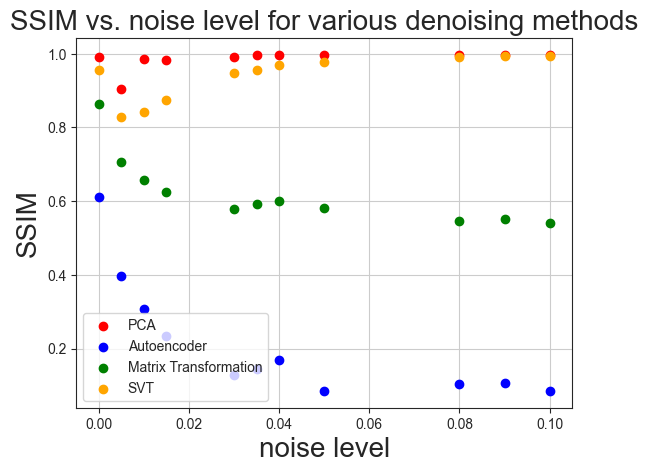

In [9]:
# Create scatter plot
plt.scatter(noise_levels, pca_stat, color='red', label='PCA')
plt.scatter(noise_levels, auto_stat, color='blue', label='Autoencoder')
plt.scatter(noise_levels, mf_stat, color='green', label='Matrix Transformation')
plt.scatter(noise_levels, svt_stat, color='orange', label='SVT')

# Labels and legend
plt.xlabel('noise level', fontsize=20)
plt.ylabel('SSIM', fontsize=20)
plt.title('SSIM vs. noise level for various denoising methods', fontsize=20)
plt.legend()
plt.grid(True)

save_path = os.path.join("out", "all_noise_2.png")
plt.savefig(save_path, dpi=300)  # High resolution and tight layout

# Show plot
plt.show()